In [43]:
!pip install yfinance pandas numpy scikit-learn xgboost statsmodels matplotlib

**Imports and Global Configuration**

This block sets up the environment. We define our starting capital, the lookback periods for our signals, and the universe of Nifty heavyweights we want to trade.

In [44]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# --- 1. CONFIGURATION ---
CAPITAL = 1_000_000
TEST_START, TEST_END = "2025-01-01", "2026-02-17"
REBALANCE_FREQ = 2
TURNOVER_PENALTY = 0.01
TARGET_VOL = 0.12
LONGS, SHORTS = 3, 3   # Concentrated high-conviction bets
STOP_LOSS_MULT = 2.0   # Essential for protecting capital

STOCKS = [
    "RELIANCE.NS","TCS.NS","INFY.NS","HDFCBANK.NS","ICICIBANK.NS","SBIN.NS",
    "KOTAKBANK.NS","AXISBANK.NS","LT.NS","ITC.NS","HINDUNILVR.NS",
    "BHARTIARTL.NS","ASIANPAINT.NS","HCLTECH.NS","MARUTI.NS","TITAN.NS","SUNPHARMA.NS"
]

##  Data Acquisition, Residual Returns & Normalization Setup

This section prepares the short-horizon trading framework by downloading fresh market data and constructing core statistical inputs.

###  Market Data
- Downloads adjusted closing prices for selected stocks and the NIFTY index.
- Forward-fills missing values to ensure continuous time series.

###  Return & Residual Computation
- Computes daily percentage returns for stocks and the index.
- Derives **residual returns** by subtracting index returns from stock returns, isolating stock-specific movement.
- Calculates 20-day rolling volatility of residual returns for short-term risk estimation.

###  Cross-Sectional Normalization
- Defines a `cs_z()` function for cross-sectional z-score normalization.
- Standardizes signals across stocks each day, ensuring comparability and balanced portfolio construction.

This forms the statistical foundation for a short-term, market-neutral signal engine.


In [45]:
# --- 2. DATA & SIGNALS ---
data = yf.download(STOCKS + ["^NSEI"], start="2024-06-01", end=TEST_END, auto_adjust=True)['Close'].ffill()
stocks = data[STOCKS]
nifty = data["^NSEI"]

stock_ret = stocks.pct_change()
nifty_ret = nifty.pct_change()
res_ret = stock_ret.sub(nifty_ret, axis=0)
rolling_vol = res_ret.rolling(20).std()

def cs_z(df):
    return df.sub(df.mean(axis=1), axis=0).div(df.std(axis=1), axis=0)

[*********************100%***********************]  18 of 18 completed


## Alpha Construction & Regime-Adaptive Signal Logic

### Factor Layer

Three short-horizon cross-sectional factors are constructed:

- **Mean Reversion**: Measures deviation from the 10-day moving average, scaled by rolling standard deviation.
- **Residual Momentum**: 10-day average of residual returns to capture short-term stock-specific trend persistence.
- **Statistical Arbitrage**: Current residual return relative to its 30-day mean, capturing temporary mispricing.

All factors are cross-sectionally z-scored to ensure comparability across stocks.

---

### Alpha Engine

The composite alpha is formed using weighted blending:

- 15% Mean Reversion  
- 50% Residual Momentum  
- 35% Statistical Arbitrage  

The combined signal is:
- Cross-sectionally normalized again
- Smoothed using a short exponential moving average (span=2) to reduce noise and turnover

---

### Regime-Adaptive Flip Logic

To improve robustness, dynamic signal conditioning is applied:

1. **Signal Performance Tracking**  
   - Measures rolling performance of the signal via lagged alpha × residual returns.
   - If recent signal performance turns negative, the alpha is flipped.

2. **Volatility Scaling & Clipping**  
   - Alpha is volatility-adjusted using a 20-day rolling standard deviation.
   - Signal strength is clipped to the range [-2, 2] to control extremes.

3. **Trend Confirmation Filter**  
   - Signals are suppressed if their sign disagrees with their short-term (2-day) trend.
   - Reduces whipsaw and unstable position changes.

In [46]:
# Alpha Factors
meanrev = cs_z((stocks - stocks.rolling(10).mean()) / stocks.rolling(10).std())
res_mom = cs_z(res_ret.rolling(10).mean())
stat_arb = cs_z(res_ret - res_ret.rolling(30).mean())

# Alpha Engine
alpha = 0.15*meanrev + 0.50*res_mom + 0.35*stat_arb
alpha = cs_z(alpha).ewm(span=2).mean()

# Alpha Flip Logic
sig_perf = (alpha.shift(1) * res_ret).mean(axis=1).rolling(10).mean()
alpha = alpha.where(sig_perf > 0, -alpha)
alpha = (alpha / alpha.rolling(20).std()).clip(-2,2)
alpha = alpha.where(np.sign(alpha) == np.sign(alpha.rolling(2).mean()), 0)

## Portfolio Execution Engine with Stop-Loss Risk Control

This section implements the live portfolio simulation layer, translating alpha signals into executable trades with embedded risk management.

---

### Daily Equity Tracking

- Computes marked-to-market portfolio value each day.
- Tracks total equity as cash + current position value.
- Maintains a running equity curve for performance analysis.

---

### Stop-Loss Risk Management

- Each position is assigned a volatility-based stop price at entry.
- Stop distance = STOP_LOSS_MULT × rolling volatility × price.
- Long positions exit if price falls below stop.
- Short positions exit if price rises above stop.
- No take-profit logic — risk control is purely downside-based.

---

### Rebalancing Logic

At each rebalance date:

1. All remaining positions are closed.
2. Alpha scores are ranked cross-sectionally.
3. Top `LONGS` and bottom `SHORTS` stocks are selected.

---

### Volatility-Adjusted Position Sizing

- Raw weights are proportional to signal strength.
- Weights are scaled inversely by rolling volatility (risk parity style).
- Weights are normalized to sum to 1.

---

### Turnover Penalty

- Penalizes large allocation shifts relative to previous weights.
- Reduces excessive trading and transaction costs.
- Weights are renormalized post-penalty.

---

### Volatility Targeting

- Portfolio exposure scaled to match `TARGET_VOL`.
- Scaling factor capped at 1.5 to prevent excessive leverage.

---

### Position Entry

- Capital allocated proportionally to weight × scaling factor.
- Position size converted to integer quantity.
- Each position is stored with:
  - Quantity (signed for long/short)
  - Volatility-based stop price

---

This engine produces a market-neutral, volatility-scaled long-short portfolio with adaptive sizing and systematic downside protection.


In [47]:
cash = CAPITAL
portfolio = {}
equity_curve = []
dates = stocks.loc[TEST_START:TEST_END].index
prev_weights = pd.Series(0.0, index=STOCKS)

for i, d in enumerate(dates):
    current_val = sum(p["qty"] * stocks.loc[d, s] for s, p in portfolio.items())
    equity = cash + current_val
    equity_curve.append(equity)

    # Risk Management: Stop Loss Only
    for s, p in list(portfolio.items()):
        curr_px = stocks.loc[d, s]
        side = np.sign(p["qty"])
        if (side == 1 and curr_px < p["stop_px"]) or (side == -1 and curr_px > p["stop_px"]):
            cash += p["qty"] * curr_px
            del portfolio[s]

    if i % REBALANCE_FREQ != 0: continue

    for s, p in list(portfolio.items()):
        cash += p["qty"] * stocks.loc[d, s]
    portfolio.clear()

    scores = alpha.loc[d].dropna()
    if len(scores) < LONGS + SHORTS: continue

    longs, shorts = scores.nlargest(LONGS), scores.nsmallest(SHORTS)
    raw_weights = pd.concat([longs.abs(), shorts.abs()]).groupby(level=0).sum()
    weights = (raw_weights / rolling_vol.loc[d, raw_weights.index]).pipe(lambda x: x/x.sum())

    weights = (weights * (1 - TURNOVER_PENALTY * (weights - prev_weights.reindex(weights.index).fillna(0)).abs().sum())).pipe(lambda x: x/x.sum())
    scale = min((TARGET_VOL / (rolling_vol.loc[d, weights.index].mean() * np.sqrt(252))), 1.5)

    for side, picks in [(1, longs.index), (-1, shorts.index)]:
        for s in picks:
            px = stocks.loc[d, s]
            if pd.isna(px) or px <= 0: continue
            qty = int((equity * weights.get(s, 0) * scale) / px)
            if qty > 0:
                v_dist_sl = STOP_LOSS_MULT * rolling_vol.loc[d, s] * px
                portfolio[s] = {
                    "qty": side * qty,
                    "stop_px": px - v_dist_sl if side == 1 else px + v_dist_sl
                }
                cash -= side * qty * px

    prev_weights = weights.reindex(STOCKS).fillna(0)

## Performance Evaluation & Risk Analytics

This section converts the simulated equity curve into a full performance and risk diagnostic report.

---

### Return & Growth Metrics

- **Total Return**: Overall capital appreciation across the test window.
- **CAGR (Compound Annual Growth Rate)**: Annualized growth rate adjusted for time.
- **Final Portfolio Value**: Ending capital after all rebalances.

---

### Risk & Stability Metrics

- **Annualized Volatility**: Standard deviation of daily returns scaled to yearly terms.
- **Sharpe Ratio**: Risk-adjusted return using total volatility.
- **Sortino Ratio**: Downside-risk-adjusted performance.
- **Max Drawdown**: Largest peak-to-trough capital decline.
- **Calmar Ratio**: CAGR divided by maximum drawdown.

---

### Trade Quality Diagnostics (Return-Based Approximation)

- **Win Rate**: Percentage of positive-return days.
- **Average Gain / Loss**: Mean positive and negative daily returns.
- **Profit Factor**: Ratio of total gains to total losses.
- **Skewness**: Asymmetry of returns distribution.
- **Kurtosis**: Tail heaviness of returns distribution.

---

### Visual Diagnostics

- **Equity Curve**: Tracks capital growth over time.
- **Drawdown Curve**: Shows magnitude and duration of capital declines.

Together, these metrics provide a complete assessment of growth, risk, stability, and distribution behavior of the trading system.



--- PERFORMANCE SUMMARY ---
Final Value:        1,101,037
Total Return:       10.1 %
CAGR:               8.93 %
Annual Volatility:  6.35 %
Sharpe Ratio:       1.4
Calmar Ratio:       2.6
Max Drawdown:       -3.43 %
Win Rate:           50.36 %
Profit Factor:      1.28
Avg Gain:           0.324 %
Avg Loss:           -0.261 %
Skewness:           -0.26
Kurtosis:           2.28


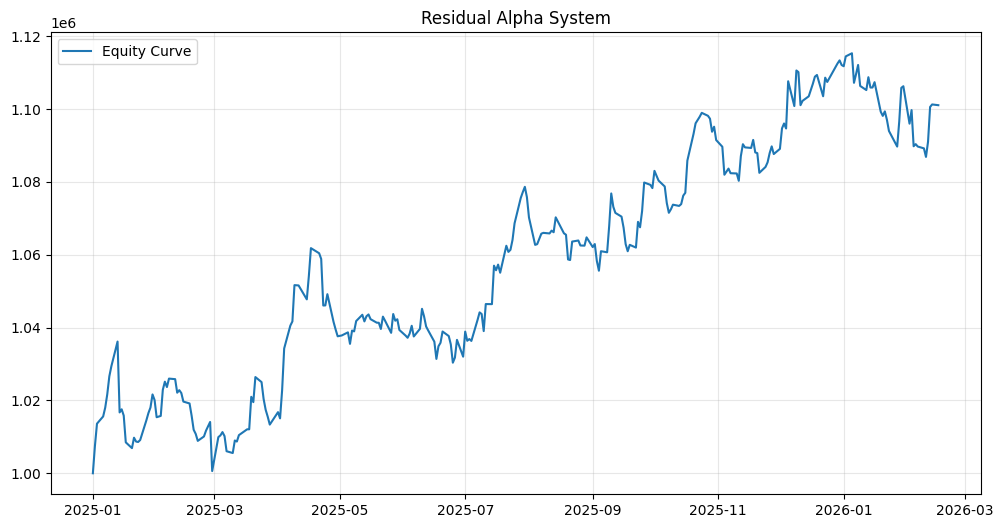

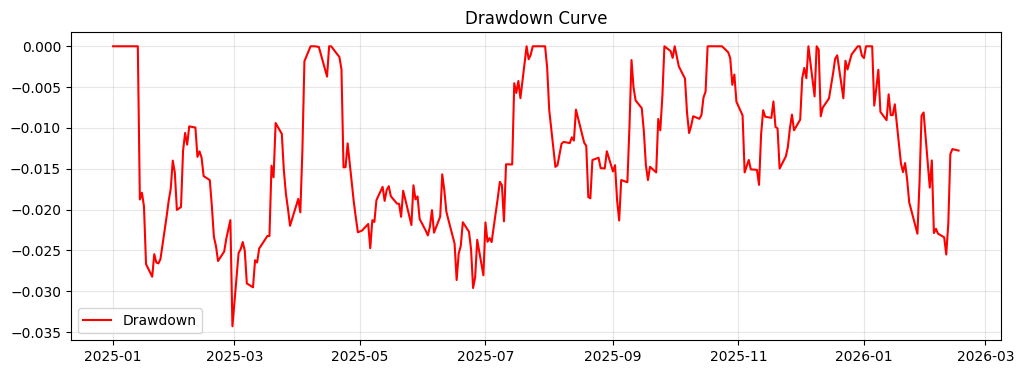

In [48]:
# ================== PERFORMANCE ==================
res_equity = pd.Series(equity_curve, index=dates)
rets = res_equity.pct_change().dropna()

# Basic Metrics
total_return = (res_equity.iloc[-1] / res_equity.iloc[0]) - 1
years = (res_equity.index[-1] - res_equity.index[0]).days / 365.25
cagr = (1 + total_return) ** (1 / years) - 1 if years > 0 else 0

ann_vol = rets.std() * np.sqrt(252)
sharpe = (rets.mean() / rets.std()) * np.sqrt(252) if rets.std() != 0 else 0

downside_std = rets[rets < 0].std() * np.sqrt(252)
sortino = (rets.mean() * np.sqrt(252)) / downside_std if downside_std != 0 else 0

cummax = res_equity.cummax()
drawdown = res_equity / cummax - 1
max_dd = drawdown.min()

calmar = cagr / abs(max_dd) if max_dd != 0 else 0

# Trade-Level Metrics (approx using daily returns)
win_rate = (rets > 0).sum() / len(rets)
avg_gain = rets[rets > 0].mean()
avg_loss = rets[rets < 0].mean()
profit_factor = abs(rets[rets > 0].sum() / rets[rets < 0].sum()) if rets[rets < 0].sum() != 0 else np.inf

skewness = rets.skew()
kurtosis = rets.kurtosis()

print("\n--- PERFORMANCE SUMMARY ---")
print(f"Final Value:        {int(res_equity.iloc[-1]):,}")
print(f"Total Return:       {round(total_return*100,2)} %")
print(f"CAGR:               {round(cagr*100,2)} %")
print(f"Annual Volatility:  {round(ann_vol*100,2)} %")
print(f"Sharpe Ratio:       {round(sharpe,2)}")
print(f"Calmar Ratio:       {round(calmar,2)}")
print(f"Max Drawdown:       {round(max_dd*100,2)} %")
print(f"Win Rate:           {round(win_rate*100,2)} %")
print(f"Profit Factor:      {round(profit_factor,2)}")
print(f"Avg Gain:           {round(avg_gain*100,3)} %")
print(f"Avg Loss:           {round(avg_loss*100,3)} %")
print(f"Skewness:           {round(skewness,2)}")
print(f"Kurtosis:           {round(kurtosis,2)}")

# Plot Equity & Drawdown
plt.figure(figsize=(12,6))
plt.plot(res_equity, label="Equity Curve")
plt.title("Residual Alpha System")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(drawdown, color="red", label="Drawdown")
plt.title("Drawdown Curve")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
